# Out-of-matrix prediction using synthetic data

### Synthetic data simulation

In [1]:
import data_simulation as sim

ds = sim.gen_matrix(1000, 400, 500, 4)
sparse_matrix = sim.sparsify(ds['matrix'], sparsity = 0.20)

In [2]:
### make a training set and a test set
import numpy as np

train_indexes = np.random.choice(sparse_matrix.shape[0], round(0.8 * sparse_matrix.shape[0]), replace = False)
test_indexes  = np.setdiff1d(np.arange(sparse_matrix.shape[0]), train_indexes)
train_indexes = np.sort(train_indexes)
test_indexes  = np.sort(test_indexes)

train_ds  = sparse_matrix[train_indexes, ]
train_fea = ds['sinfo'][train_indexes, ]
test_ds   = sparse_matrix[test_indexes, ]
test_fea  = ds['sinfo'][test_indexes, ]

In [3]:
### plot train_ds
import matplotlib.pyplot as plt

plt.imshow(train_ds, cmap = 'jet')
plt.savefig('out_pred_train_ds.png')

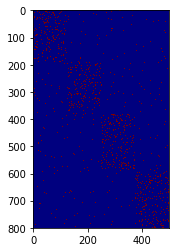

In [4]:
### plot the corresponding features of the training set

plt.imshow(train_fea, cmap = 'jet')
plt.savefig('out_pred_train_fea.png')

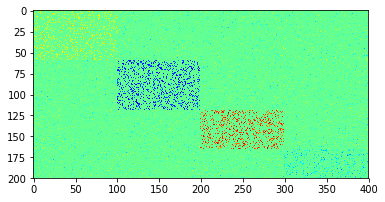

In [5]:
### plot the testing dataset

plt.imshow(test_ds, cmap = 'jet')
plt.savefig('out-pred-test-ds.png')

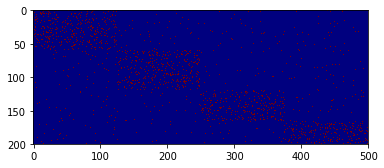

In [6]:
### plot the corresponding features of the testing dataset

plt.imshow(test_fea, cmap = 'jet')
plt.savefig('out-pred-test-fea.png')

### Train the model

In [7]:
### make scipy sparse matrix 
from scipy.sparse import coo_matrix
import smurff

sp_train_ds  = coo_matrix(train_ds)
sp_train_fea = coo_matrix(train_fea)

sp_train_ds1, sp_train_ds2 = smurff.make_train_test(sp_train_ds, 0.01)
print(sp_train_ds1.nnz)
print(sp_train_ds2.nnz)

63210
638


In [8]:
### train the model
import smurff

session = smurff.MacauSession(
                       Ytrain     = sp_train_ds1,
                       Ytest      = sp_train_ds2,
                       side_info  = [sp_train_fea, None],
                       num_latent = 4,
                       burnin     = 400,
                       nsamples   = 1500,
                       save_freq  = 1,
                       save_prefix= "syn-out-matrix-pred/save",
                       verbose    = 1,)
predictions = session.run()

PythonSession {
  Data: {
    Type: ScarceMatrixData [with NAs]
    Component-wise mean: 0.131928
    Component-wise variance: 6.83443
    Noise: Fixed gaussian noise with precision: 5.00
    Size: 63210 [800 x 400] (19.75%)
  }
  Model: {
    Num-latents: 4
  }
  Priors: {
    0: MacauPrior
     SideInfo: SparseDouble [800, 500]
     Method: CG Solver
     Tol: 1.00e-06
     BetaPrecision: 5.00
    1: NormalPrior
  }
  Result: {
    Test data: 638 [800 x 400] (0.20%)
  }
  Version: v0.12.3
  Iterations: 400 burnin + 1500 samples
  Save model: every 1 iteration
  Save prefix: C:\Users\TLeVan3\OneDrive - JNJ\cgOperational\macau_smurff\syn-out-matrix-pred/save
  Save extension: .ddm
}

Initial:   0/0 RMSE: nan (1samp: nan) U: [ 0: 0.00,1: 0.00 ] took 0.0s
 Burnin:   1/400 RMSE: nan (1samp: 2.49) U: [ 0: 18.12,1: 23.85 ] took 0.0s
 Burnin:   2/400 RMSE: nan (1samp: 1.87) U: [ 0: 49.42,1: 37.75 ] took 0.0s
 Burnin:   3/400 RMSE: nan (1samp: 1.16) U: [ 0: 56.72,1: 40.80 ] took 0.0s
 Burnin:

### Out-of-matrix prediction

In [9]:
# predictor = smurff.PredictSession.fromRootFile("syn-out-matrix-pred/save-root.ini")
predictor = session.makePredictSession()
print(predictor)

PredictSession with 1500 samples
  Data shape = [800, 400]
  Beta shape = [500, 0]
  Num latent = 4


In [10]:
def predict_out_of_matrix_1s(side_info_matrix, sample_predictor):
    """Out-of-matrix prediction using one sample
    
    Args:
        side_info_matrix: numpy side info matrix
        sample_predictor: Smurff sample object
    
    Returns:
        numpy fully predicted matrix
        
    """
    U, V = sample_predictor.latents
    Umean, Vmean = sample_predictor.latent_means
    Ubeta, Vbeta = sample_predictor.betas
    
    wU = side_info_matrix.dot(Ubeta.transpose()) + Umean
    m  = np.matmul(wU, V)
    
    return m

def pred_out_of_matrix(side_info_matrix, predictor):
    """Out-of-matrix prediction using all of the samples
    
    Args:
        side_info_matrix: numpy side info matrix
        predictor:        Smurff PredictSession
    
    Returns:
        numpy fully predicted matrix (obtained by averaging)
        
    """
    
    predictions = np.array([predict_out_of_matrix_1s(side_info_matrix, s) for s in predictor.samples])
    
    return predictions.mean(axis = 0)

In [11]:
pred_test_ds = pred_out_of_matrix(test_fea, predictor)

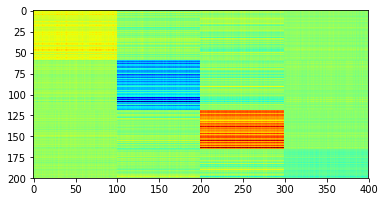

In [12]:
plt.imshow(pred_test_ds, cmap = 'jet')
plt.savefig('out-pred-predicted-matrix.png')

### Calculate RMSE

In [13]:
import utilities as util

#rmse = util.cal_out_matrix_rmse(test_ds, test_fea, predictor)
#rmse

pred_ds = util.pred_out_of_matrix(test_fea, predictor)  

In [14]:
# calculate rmse for the non-missing values in the test dataset
from scipy.sparse import find
from sklearn.metrics import mean_squared_error
import math

(i, j, y_true) = find(test_ds)        
y_pred = [pred_ds[i[idx], j[idx]] for idx in np.arange(len(i))] 
rmse = math.sqrt(mean_squared_error(y_true, y_pred))
rmse

1.3801289809229924

# K-fold cross validation

In [15]:
cv_res = util.cross_validate(y_matrix = coo_matrix(sparse_matrix), 
                        y_fea    = coo_matrix(ds['sinfo']), 
                        cv       = 3, 
                        log_folder = "H:\\test",
                        k        = 4, 
                        nburnins = 10, 
                        nsamples = 20, 
                        out_of_matrix = False)
cv_res

*** Cross validation  0  ***
PythonSession {
  Data: {
    Type: ScarceMatrixData [with NAs]
    Component-wise mean: 0.0737325
    Component-wise variance: 7.05355
    Noise: Fixed gaussian noise with precision: 5.00
    Size: 53326 [667 x 400] (19.99%)
  }
  Model: {
    Num-latents: 4
  }
  Priors: {
    0: MacauPrior
     SideInfo: SparseDouble [667, 500]
     Method: CG Solver
     Tol: 1.00e-06
     BetaPrecision: 5.00
    1: NormalPrior
  }
  Result: {
    Test data: 5 [667 x 400] (0.00%)
  }
  Version: v0.12.3
  Iterations: 10 burnin + 20 samples
  Save model: every 1 iteration
  Save prefix: H:\test\0/save
  Save extension: .ddm
}

Initial:   0/0 RMSE: nan (1samp: nan) U: [ 0: 0.00,1: 0.00 ] took 0.0s
 Burnin:   1/10 RMSE: nan (1samp: 3.85) U: [ 0: 16.31,1: 27.17 ] took 0.0s
 Burnin:   2/10 RMSE: nan (1samp: 1.64) U: [ 0: 51.09,1: 36.28 ] took 0.0s
 Burnin:   3/10 RMSE: nan (1samp: 1.11) U: [ 0: 56.37,1: 38.52 ] took 0.0s
 Burnin:   4/10 RMSE: nan (1samp: 1.00) U: [ 0: 58.64,1

,index,rmse,train_time,pred_time,folder
0,0,1.377009,8.037556,0.046124,H:\test\0
1,1,1.356721,7.562632,0.057157,H:\test\1
2,2,1.376990,8.219568,0.069182,H:\test\2
